In [1]:
# Import packages
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import requests
import rasterio
import xarray as xr
import rioxarray as rio
import numpy as np
import matplotlib.pyplot as plt
import mercantile as m
from shapely.geometry import shape, Polygon, Point, box
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from zipfile import ZipFile
import shutil

# NOTE: change to your own path when setting workspace
# ws = r'C:\Users\emers\.rainfall'
ws = r'C:\Users\sgartrel\Desktop\geog490\final-proj\RainfallCollection\data'


### Step 1: Get Data
Download vector data for the state geometry and the geometry of buildings within it, and store these datasets in geodataframes. The vector data can be downloaded for any US State that you have a precipitation cdf for--just manipulate the `state` variable in the following code cell.

##### References:
- [Global Footprints Dataset](https://github.com/microsoft/GlobalMLBuildingFootprints)
- [Unzip files in python (geeks for geeks)](https://www.geeksforgeeks.org/unzipping-files-in-python/)

In [2]:
# set target state
state = 'arizona'

# get state bounds
state_gdf = gpd.read_file(
    f'https://raw.githubusercontent.com/glynnbird/usstatesgeojson/master/{state}.geojson', crs='epsg:4326'
)

In [3]:
# get building data
filename = f'{state.title()}.geojson.zip'
filepath = os.path.join(ws, filename)
url = f'https://usbuildingdata.blob.core.windows.net/usbuildings-v2/{filename}'

with requests.get(url, allow_redirects=True, stream=True) as r:
    with open(filepath, 'wb') as f:
        shutil.copyfileobj(r.raw, f)
        print('zip downloaded')

        with ZipFile(filepath, 'r') as z:
            z.extractall(
                path=ws
                )

print(f'file unzipped successfully ({os.path.getsize(filepath.strip(".zip")) / 1000000} MB)')

zip downloaded
file unzipped successfully (845.767832 MB)


In [4]:
# read buildings into geojson
buildings_gdf = gpd.read_file(filepath.strip('.zip'), crs='epsg:4326')
buildings_gdf.to_crs('epsg:32612')
print('read into dataframe successfully')

read into dataframe successfully


### Step 2: Prep the NC file
Remove some dimensions and summarize across the `time` attribute to preview
- `max` precip in the timespan
- `min` precip in the timespan
- `mean` precip among the timespan

##### References:
- [dropping the `expver` variable](https://code.mpimet.mpg.de/boards/1/topics/8961)

In [5]:
# load precip data
xds = xr.open_dataset(os.path.join(ws, 'precip.nc'))

# drop the "expver" dimension
no_expver = xds.reduce(np.nansum, dim='expver')

# get mean, max, min precipitation over the 10 year period
mean = no_expver.reduce(np.mean, dim='time', keep_attrs=True)
max = no_expver.reduce(np.max, dim='time', keep_attrs=True)
min = no_expver.reduce(np.min, dim='time', keep_attrs=True)

# verify time dimension has been removed from each
for i in [max, mean, min]:
    assert 120 not in i.to_array().shape 

mean_df = mean.to_dataframe()
max_df = max.to_dataframe()
min_df = min.to_dataframe()

print(mean_df.tail(5))
print(max_df.tail(5))
print(min_df.tail(5))


                          tp
longitude latitude          
-108.0    32.00     0.000645
          31.75     0.000628
          31.50     0.000587
          31.25     0.000650
          31.00     0.000684
                          tp
longitude latitude          
-108.0    32.00     0.003283
          31.75     0.003353
          31.50     0.003656
          31.25     0.004519
          31.00     0.004999
                     tp
longitude latitude     
-108.0    32.00     0.0
          31.75     0.0
          31.50     0.0
          31.25     0.0
          31.00     0.0


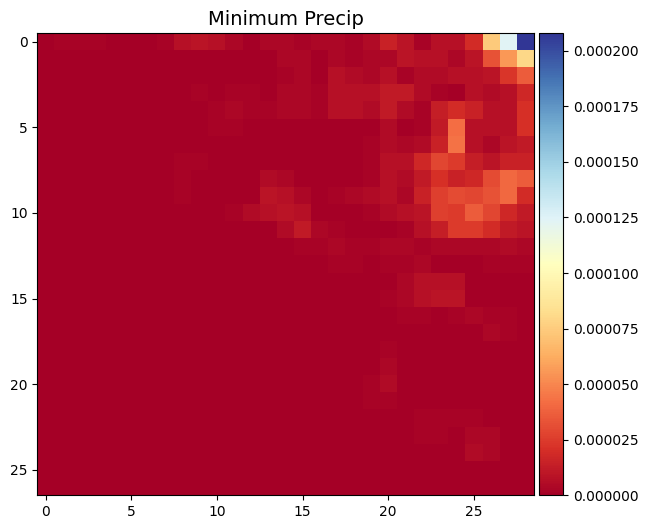

In [6]:
# Plot Minimums
fig, ax = plt.subplots(figsize=(10,6))
im1 = ax.imshow(min.to_array()[0], cmap='RdYlBu')
ax.set_title("Minimum Precip", fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

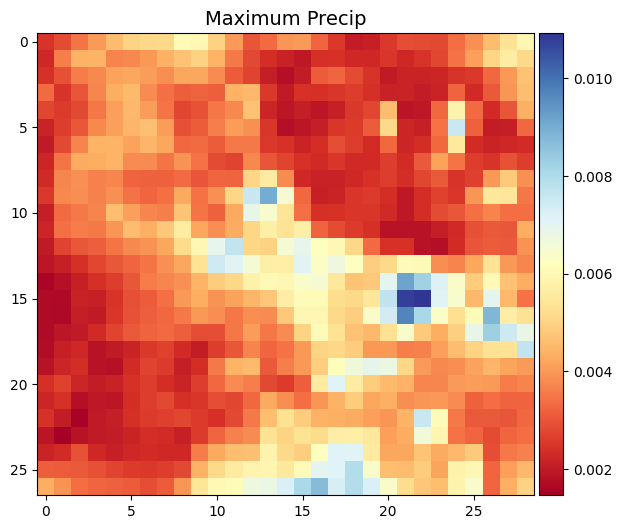

In [7]:
# Plot Maximums
fig, ax = plt.subplots(figsize=(10,6))
im1 = ax.imshow(max.to_array()[0], cmap='RdYlBu')
ax.set_title("Maximum Precip", fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

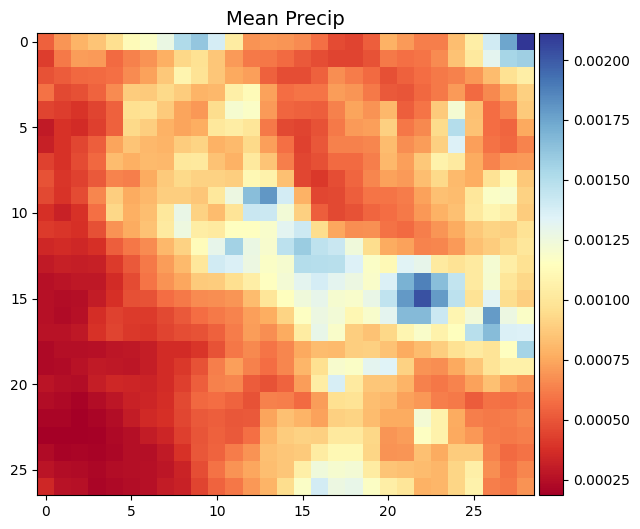

In [8]:
# Plot Means
fig, ax = plt.subplots(figsize=(10,6))
im1 = ax.imshow(mean.to_array()[0], cmap='RdYlBu')
ax.set_title("Mean Precip", fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

### Step 3: Reproject and Read into Rasterio
As you can see from the axes of the above plots, the cdf file is still in degrees that count up from its corners, so it appears unaware of its location. Creating a spatially-aware raster is necessary before analysis can be perfomed between buildings and precip

In [9]:
# Converts the NC file with precipitation data to A Raster
precip = no_expver['tp']
precip = precip.rio.set_spatial_dims(x_dim='latitude', y_dim='longitude')
reordered = precip.transpose('time', 'latitude', 'longitude')
reordered.rio.write_crs('EPSG:4326', inplace=True)
reordered.rio.to_raster(os.path.join(ws, 'precip_raster.tiff'))

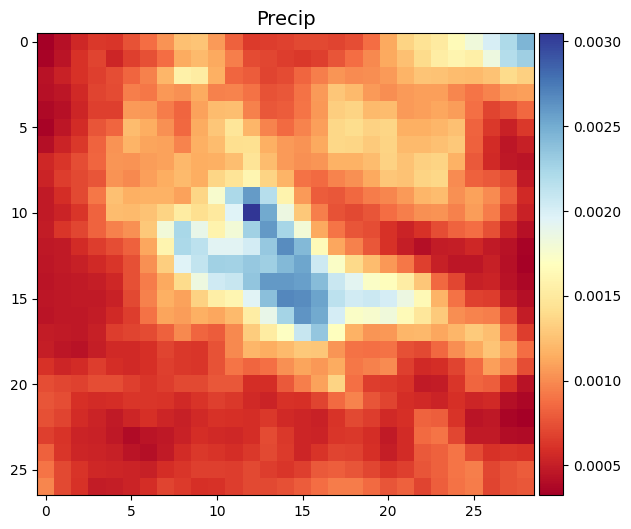

In [10]:
# Opens raster created in last cell
precip_raster = rasterio.open(os.path.join(ws, 'precip_raster.tiff'))  

# Reads the raster with the band representing the month, 1 being Jan. 2013
precip_array = precip_raster.read(1)

fig, ax = plt.subplots(figsize=(10,6))
im1 = ax.imshow(precip_array, cmap='RdYlBu')

ax.set_title("Precip", fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

In [11]:
# clip buildings (for speedy development)
test = gpd.read_file(
    os.path.join(ws, 'test.geojson'),
    crs='epsg:4326'
    ).to_crs(
    'epsg:32612'
    )

subset = gpd.clip(buildings_gdf.to_crs('epsg:32612'), test)

c:\Users\sgartrel\Anaconda3\envs\Rainfall\lib\site-packages\geopandas\tools\clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [12]:
# set bldg = buildings_gdf for complete analysis
# bldg = subset
bldg = buildings_gdf
precip = rasterio.open(os.path.join(ws, 'precip_raster.tiff'))

# add necesasry fields to building data
bldg['area_m2'] = bldg['geometry'].area

bldg = bldg.to_crs('epsg:4326') # necessary due to GDAL driver drama. Area is still accurate bc derived from UTM

bldg['centroid'] = bldg['geometry'].centroid


C:\Users\sgartrel\AppData\Local\Temp\ipykernel_33892\626458336.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bldg['area_m2'] = bldg['geometry'].area
C:\Users\sgartrel\AppData\Local\Temp\ipykernel_33892\626458336.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bldg['centroid'] = bldg['geometry'].centroid


epsg:4326 GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]


<AxesSubplot: >

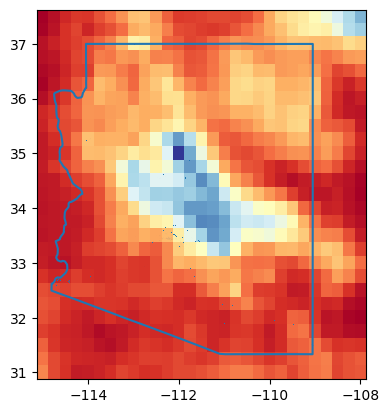

In [13]:
# this step takes about an hour for the full building dataset

from rasterio.plot import show

fig, ax = plt.subplots()

# transform rasterio plot to real world coords
extent=[precip.bounds[0], precip.bounds[2], precip.bounds[1], precip.bounds[3]]
ax = rasterio.plot.show(precip, extent=extent, ax=ax, cmap='RdYlBu')
state_precip = state_gdf.boundary.plot(ax=ax)
print(bldg.crs, precip.crs)


coord_list = [(x,y) for x,y in zip(bldg['centroid'].x , bldg['centroid'].y)]
bldg['precip_m'] = [x for x in precip.sample(coord_list)]
bldg.plot(ax=state_precip)

### Step 4: Do Some Actual Analysis
Now that the raster is georeferenced and its values have been successfully ported to the geodataframe, we can begin summarizing and drawing conclusions about the state's rainwater harvesting potential. Some facts to note:
- AZ'  driest month: June
- AZ's wettest month: March
- AZ's monsoon season: June-September
- Rainfall is measured in meters for this dataset
    - the base area of any rain gauge is linearly related to how much rain it catches, meaning that precip data in meters can be simultaneously interpreted as mm per square meter/foot/mile/etc. 

The process:
- First, we filter out buildings that are too big to count as residential houses, a subjective threshold we've defined as 200 square meters.
- Then, we summarize precipitation data spanning the 10 year period for each building, in terms of harvest amounts (m3)

#### References:
- [Arizona Weather](https://www.rssweather.com/climate/Arizona/Phoenix/#:~:text=The%20driest%20month%20in%20Phoenix,March%20is%20the%20wettest%20month.)

In [53]:
# this cell takes about 3 minutes for the full dataset
# define parameters (area threshold in meters, daily residential usage in gallons)
residential_roof = 200
residential_usage = 146

# drop non-residential sized buildings and get water usage in cubic meters/month (converted from gallons per day)
bldg = bldg[bldg['area_m2'] <= residential_roof]
bldg['usage_m3'] = (residential_usage * 30 * 3.78541) / 1000

# summarize the precip array
bldg['mean_precip_m'] = bldg['precip_m'].apply(lambda x: np.mean(x))
bldg['min_precip_m'] = bldg['precip_m'].apply(lambda x: np.min(x))
bldg['max_precip_m'] = bldg['precip_m'].apply(lambda x: np.max(x))

# get harvest values in cubic meters
bldg['mean_harvest_m3'] = bldg['mean_precip_m'] * bldg['area_m2']
bldg['min_harvest_m3'] = bldg['min_precip_m'] * bldg['area_m2']
bldg['max_harvest_m3'] = bldg['max_precip_m'] * bldg['area_m2']

# average the 3rd month of every year in 120 months
bldg['mar_precip'] = bldg['precip_m'].apply(lambda x: np.mean(
    [
        x[month] for month in range(3, (len(x)-1), 12)
    ]
))

# average the 6th month of every year in 120 months
bldg['jun_precip'] = bldg['precip_m'].apply(lambda x: np.mean(
    [
        x[month] for month in range(6, (len(x)-1), 12)
    ]
))

# average monsoon season (6th - 9th month every year)


bldg

release capture_dates_range  \
0              1                       
1              1                       
2              1                       
3              1                       
4              1                       
...          ...                 ...   
2738727        1                       
2738728        1                       
2738729        1                       
2738730        1                       
2738731        1                       

                                                  geometry       area_m2  \
0        POLYGON ((-109.04282 36.82605, -109.04279 36.8...  1.900400e-08   
1        POLYGON ((-109.04393 35.65962, -109.04405 35.6...  8.131000e-09   
2        POLYGON ((-109.04423 35.65913, -109.04412 35.6...  1.957200e-08   
3        POLYGON ((-109.04562 35.66014, -109.04566 35.6...  6.230000e-09   
4        POLYGON ((-109.04577 35.66066, -109.04582 35.6...  9.063000e-09   
...                                                    ...           ...   
2738727  POLYGON ((-114.79429 32.49497, -114.79420 32.4...  1.539400e-08   
2738728  POLYGON ((-114.79430 32.50759, -114.79411 32.5...  8.170000e-09   
2738729  POLYGON ((-114.79435 32.50851, -114.79441 32.5...  9.858000e-09   
2738730  POLYGON ((-114.79558 32.50762, -114.79557 32.5...  1.033900e-08   
2738731  POLYGON ((-114.80896 32.62914, -114.80893 32.6...  6.972000e-09   

                            centroid  \
0        POINT (-109.04280 36.82616)   
1        POINT (-109.04401 35.65966)   
2        POINT (-109.04416 35.65919)   
3        POINT (-109.04569 35.66009)   
4        POINT (-109.04579 35.66058)   
...                              ...   
2738727  POINT (-114.79425 32.49505)   
2738728  POINT (-114.79420 32.50761)   
2738729  POINT (-114.79438 32.50842)   
2738730  POINT (-114.79550 32.50759)   
2738731  POINT (-114.80899 32.62919)   

                                                  precip_m   usage_m3  \
0        [0.0009784424, 0.0003987113, 0.00034337165, 0....  16.580096   
1        [0.0011691302, 0.00070191175, 0.0003987113, 0....  16.580096   
2        [0.0011691302, 0.00070191175, 0.0003987113, 0....  16.580096   
3        [0.0011691302, 0.00070191175, 0.0003987113, 0....  16.580096   
4        [0.0011691302, 0.00070191175, 0.0003987113, 0....  16.580096   
...                                                    ...        ...   
2738727  [0.00070374506, 2.1002255e-05, 0.00012018019, ...  16.580096   
2738728  [0.00070374506, 2.1002255e-05, 0.00012018019, ...  16.580096   
2738729  [0.00070374506, 2.1002255e-05, 0.00012018019, ...  16.580096   
2738730  [0.00070374506, 2.1002255e-05, 0.00012018019, ...  16.580096   
2738731  [0.00054356083, 3.0503143e-05, 0.00010101125, ...  16.580096   

         mean_precip_m  min_precip_m  max_precip_m  mean_harvest_m3  \
0             0.000707      0.000000      0.003231     1.343490e-11   
1             0.001023      0.000025      0.003475     8.319550e-12   
2             0.001023      0.000025      0.003475     2.002586e-11   
3             0.001023      0.000025      0.003475     6.374468e-12   
4             0.001023      0.000025      0.003475     9.273162e-12   
...                ...           ...           ...              ...   
2738727       0.000248      0.000000      0.002715     3.811936e-12   
2738728       0.000248      0.000000      0.002715     2.023095e-12   
2738729       0.000248      0.000000      0.002715     2.441085e-12   
2738730       0.000248      0.000000      0.002715     2.560193e-12   
2738731       0.000232      0.000000      0.002238     1.620425e-12   

         min_harvest_m3  max_harvest_m3  mar_precip  jun_precip  \
0          0.000000e+00    6.140244e-11    0.000469    0.000841   
1          2.019419e-13    2.825702e-11    0.000575    0.001922   
2          4.860911e-13    6.801703e-11    0.000575    0.001922   
3          1.547286e-13    2.165063e-11    0.000575    0.001922   
4          2.250891e-13    3.149593e-11    0.000575    0.001922   
..

In [54]:
# now, compute deficit between water used and harvested per month

# deficit under average conditions (mean precip)
bldg['mean_deficit_m3'] = bldg['usage_m3'] - bldg['mean_harvest_m3']

# deficit under optimal conditions (max precip)
bldg['wet_deficit_m3'] = bldg['usage_m3'] - bldg['max_harvest_m3']

# deficit under most arid conditions (min precip)
bldg['arid_deficit_m3'] = bldg['usage_m3'] - bldg['min_harvest_m3']

In [16]:
# statewide map is incredibly underwhelming for 10 minutes of load time
# base = state_gdf.boundary.plot(edgecolor='black')
# bldg.plot(ax=base, column='mean_deficit_m3', cmap='Blues')

<AxesSubplot: >

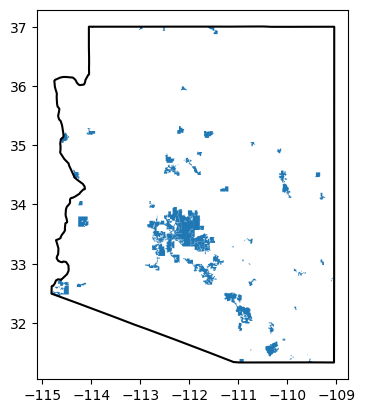

In [17]:
# get Arizona cities to break down data
cities = gpd.read_file(os.path.join(ws, 'az_cities.geojson')).set_crs('epsg:3785')
cities = cities.to_crs('epsg:4326')
city_lyr = cities.plot()
state_gdf.boundary.plot(ax=city_lyr, edgecolor='black')

In [55]:
# join city data to buildings (about 5 min with entire dataset)
bldgs_by_city = bldg.sjoin(cities)
phnx = bldgs_by_city[bldgs_by_city['NAME'] == 'PHOENIX']
flag = bldgs_by_city[bldgs_by_city['NAME'] == 'FLAGSTAFF']
pres = bldgs_by_city[bldgs_by_city['NAME'] == 'PRESCOTT']
tucs = bldgs_by_city[bldgs_by_city['NAME'] == 'TUCSON']



FLAGSTAFF:
mean annual precip (m):                 0.001616136054508388
deficit under average conditions (m^3): 16.580095799947387
deficit under wettest conditions (m^3): 16.58009579974245
deficit under driest conditions (m^3):  16.58009579999972


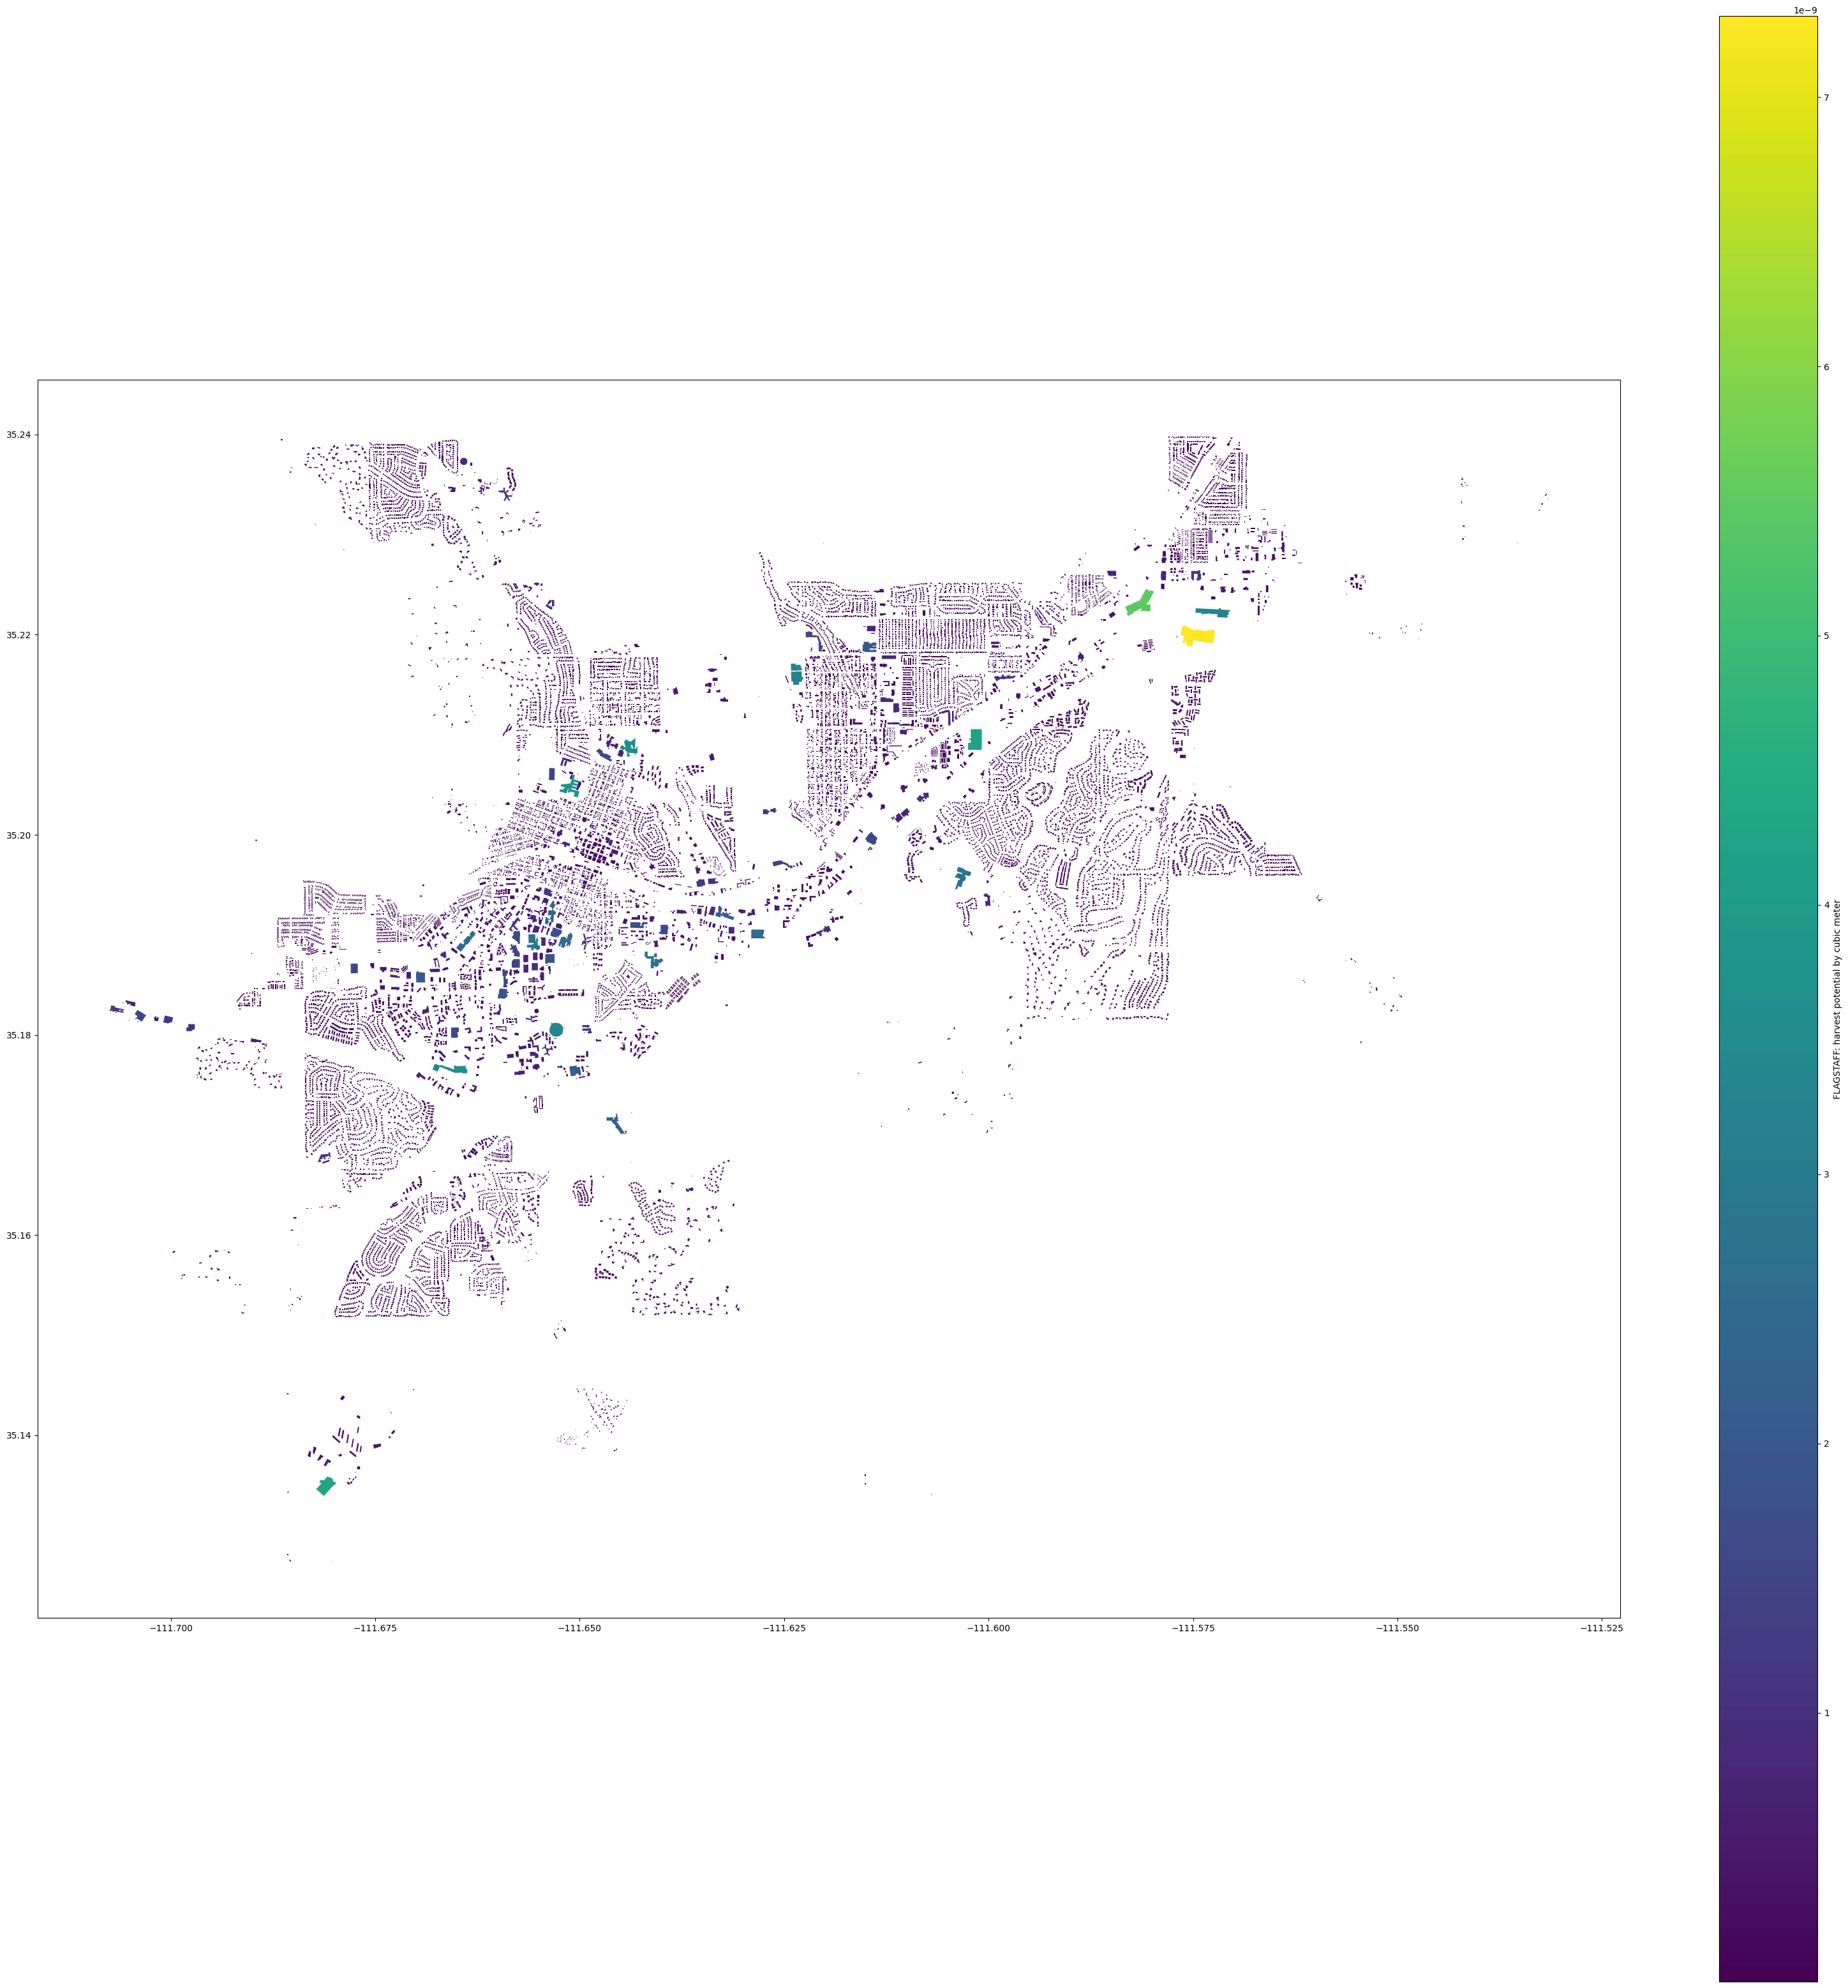

In [56]:
print("\n\nFLAGSTAFF:")
print(f'mean annual precip (m):                 {flag["mean_precip_m"].mean()}')
print(f'deficit under average conditions (m^3): {flag["mean_deficit_m3"].mean()}')
print(f'deficit under wettest conditions (m^3): {flag["wet_deficit_m3"].mean()}')
print(f'deficit under driest conditions (m^3):  {flag["arid_deficit_m3"].mean()}')

flag_plt = flag.plot(column='mean_harvest_m3',
        figsize=(40, 40),
        legend=True,
        legend_kwds={'label': "FLAGSTAFF: harvest potential by cubic meter"})



PRESCOTT:
mean annual precip (m):                 0.0012815091758966446
deficit under average conditions (m^3): 16.58009579996124
deficit under wettest conditions (m^3): 16.5800957997962
deficit under driest conditions (m^3):  16.580095800000002


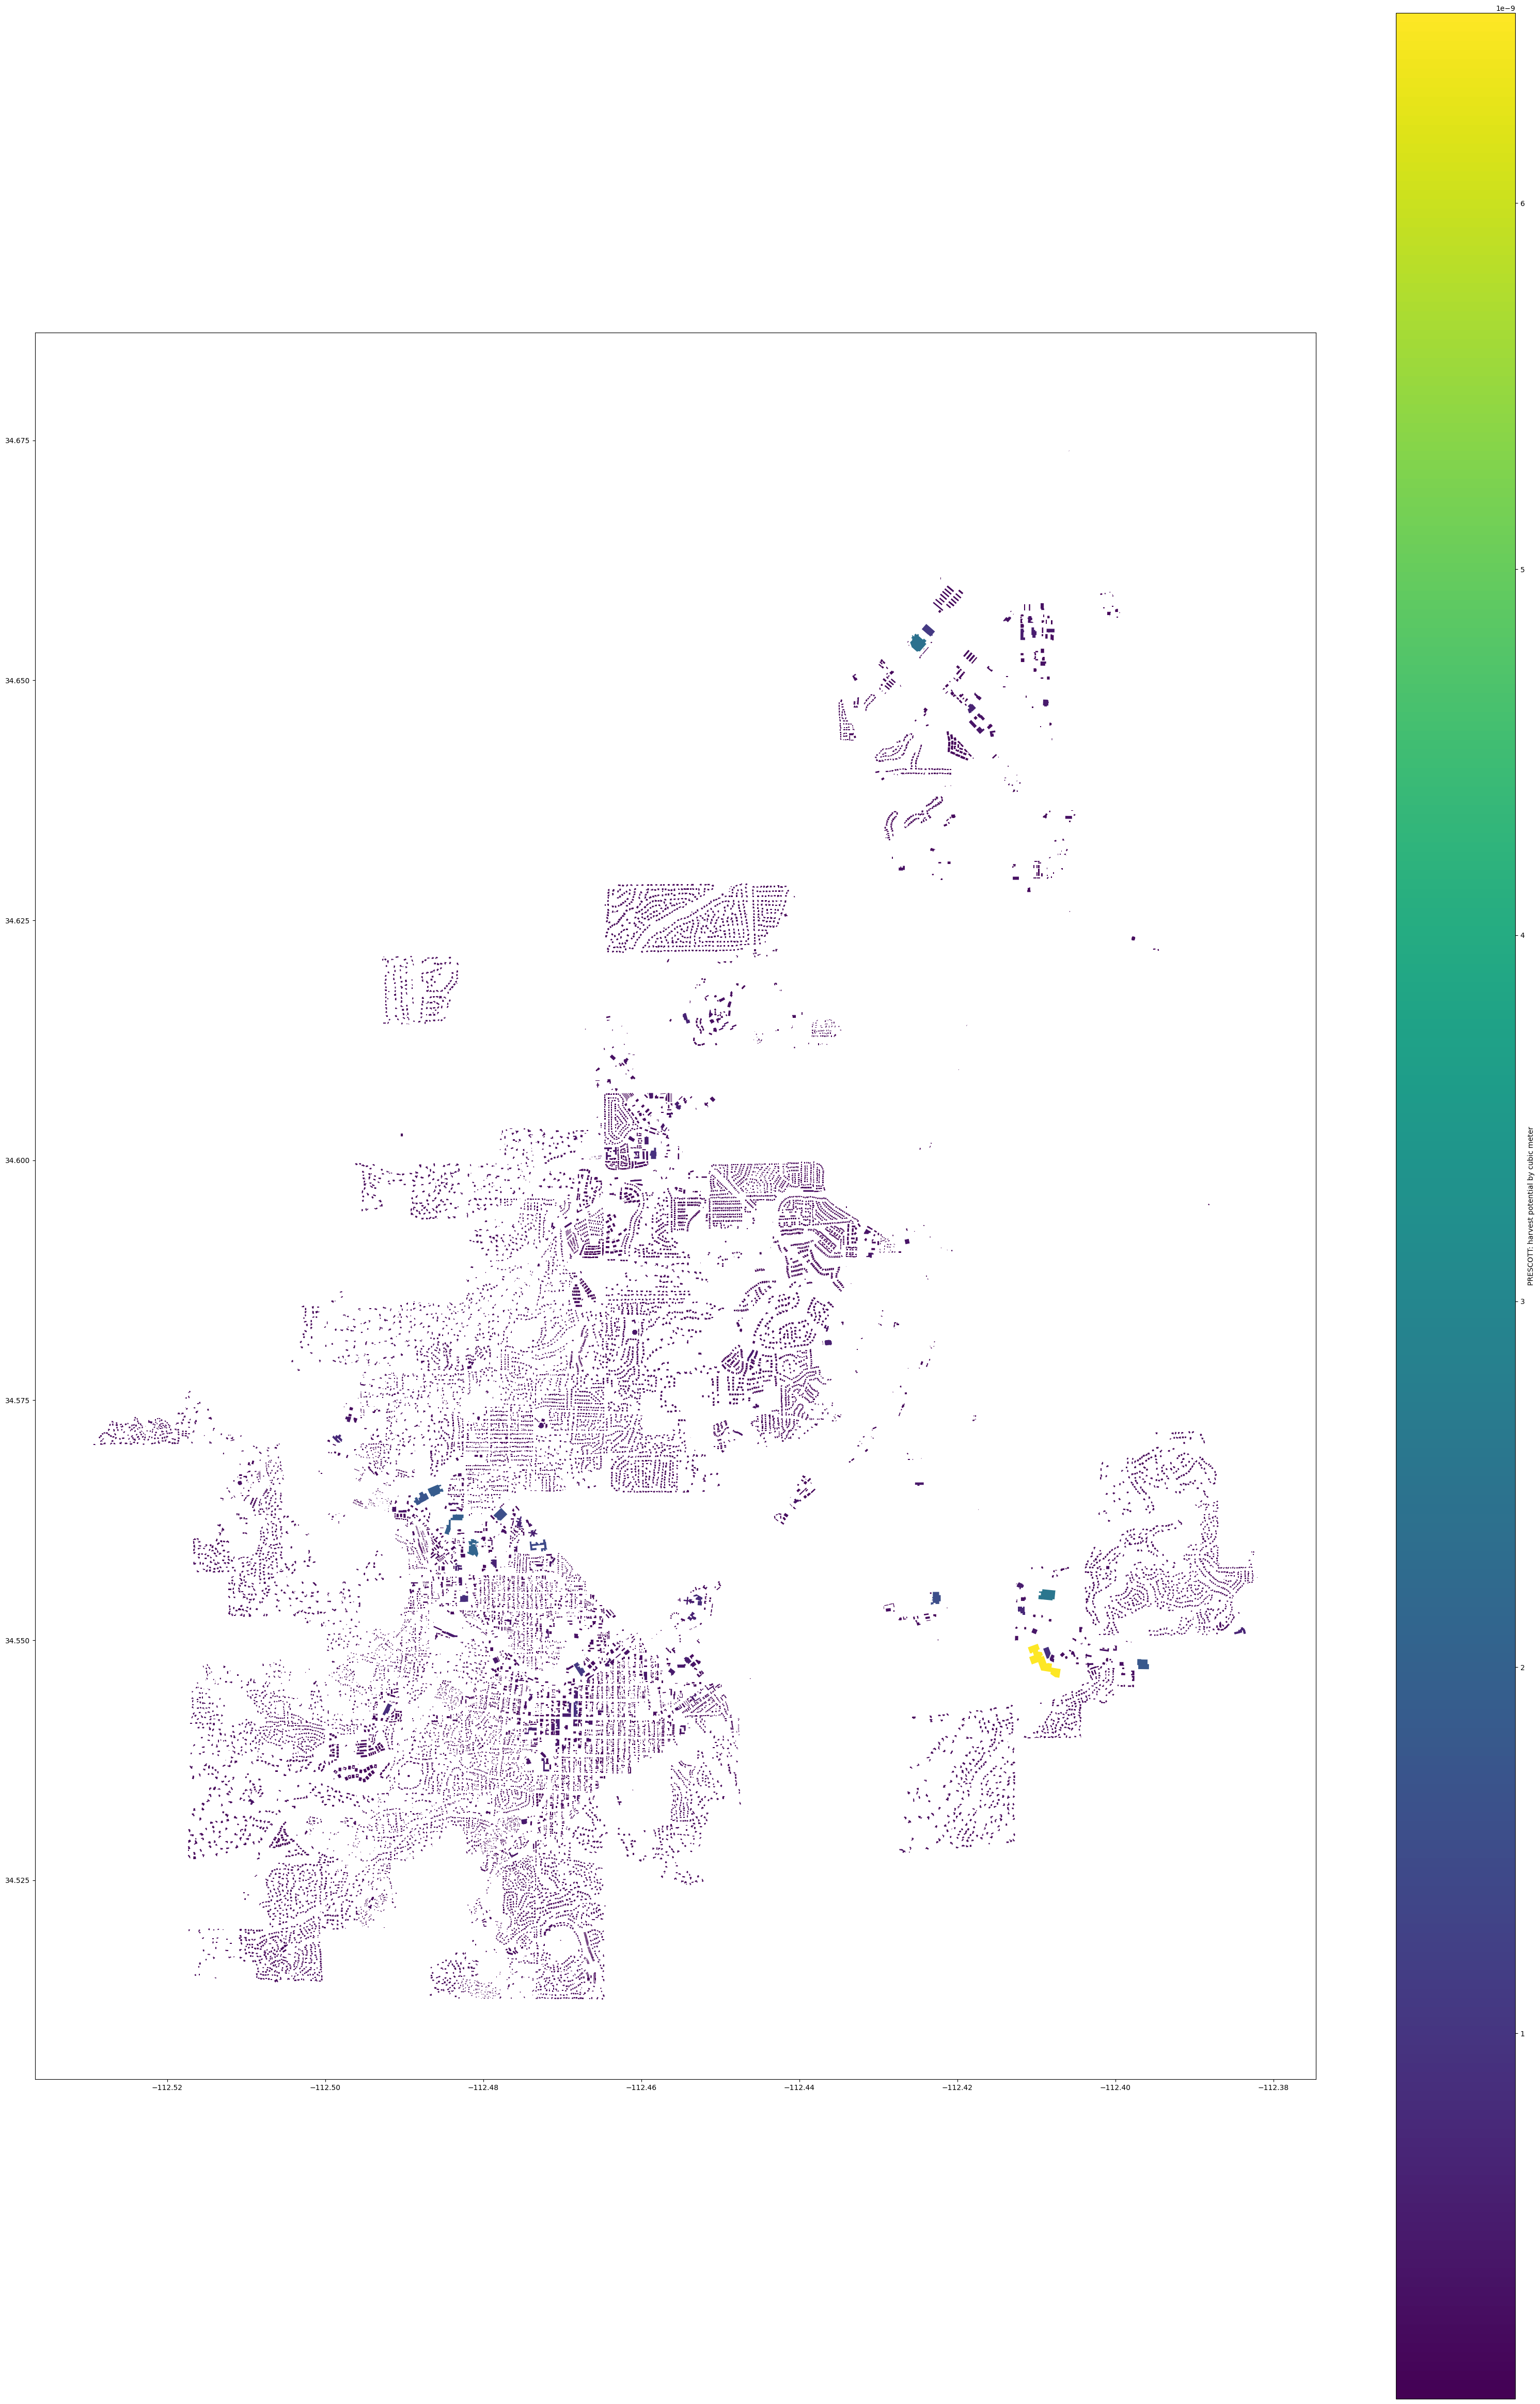

In [57]:
print("\n\nPRESCOTT:")
print(f'mean annual precip (m):                 {pres["mean_precip_m"].mean()}')
print(f'deficit under average conditions (m^3): {pres["mean_deficit_m3"].mean()}')
print(f'deficit under wettest conditions (m^3): {pres["wet_deficit_m3"].mean()}')
print(f'deficit under driest conditions (m^3):  {pres["arid_deficit_m3"].mean()}')

pres_plt = pres.plot(column='mean_harvest_m3',  
           figsize=(40, 60),
           legend=True,
           legend_kwds={'label': "PRESCOTT: harvest potential by cubic meter"})



PHOENIX:
mean annual precip (m):                 0.0007173418998718262
deficit under average conditions (m^3): 16.58009579997772
deficit under wettest conditions (m^3): 16.580095799878674
deficit under driest conditions (m^3):  16.58009579999999


<AxesSubplot: >

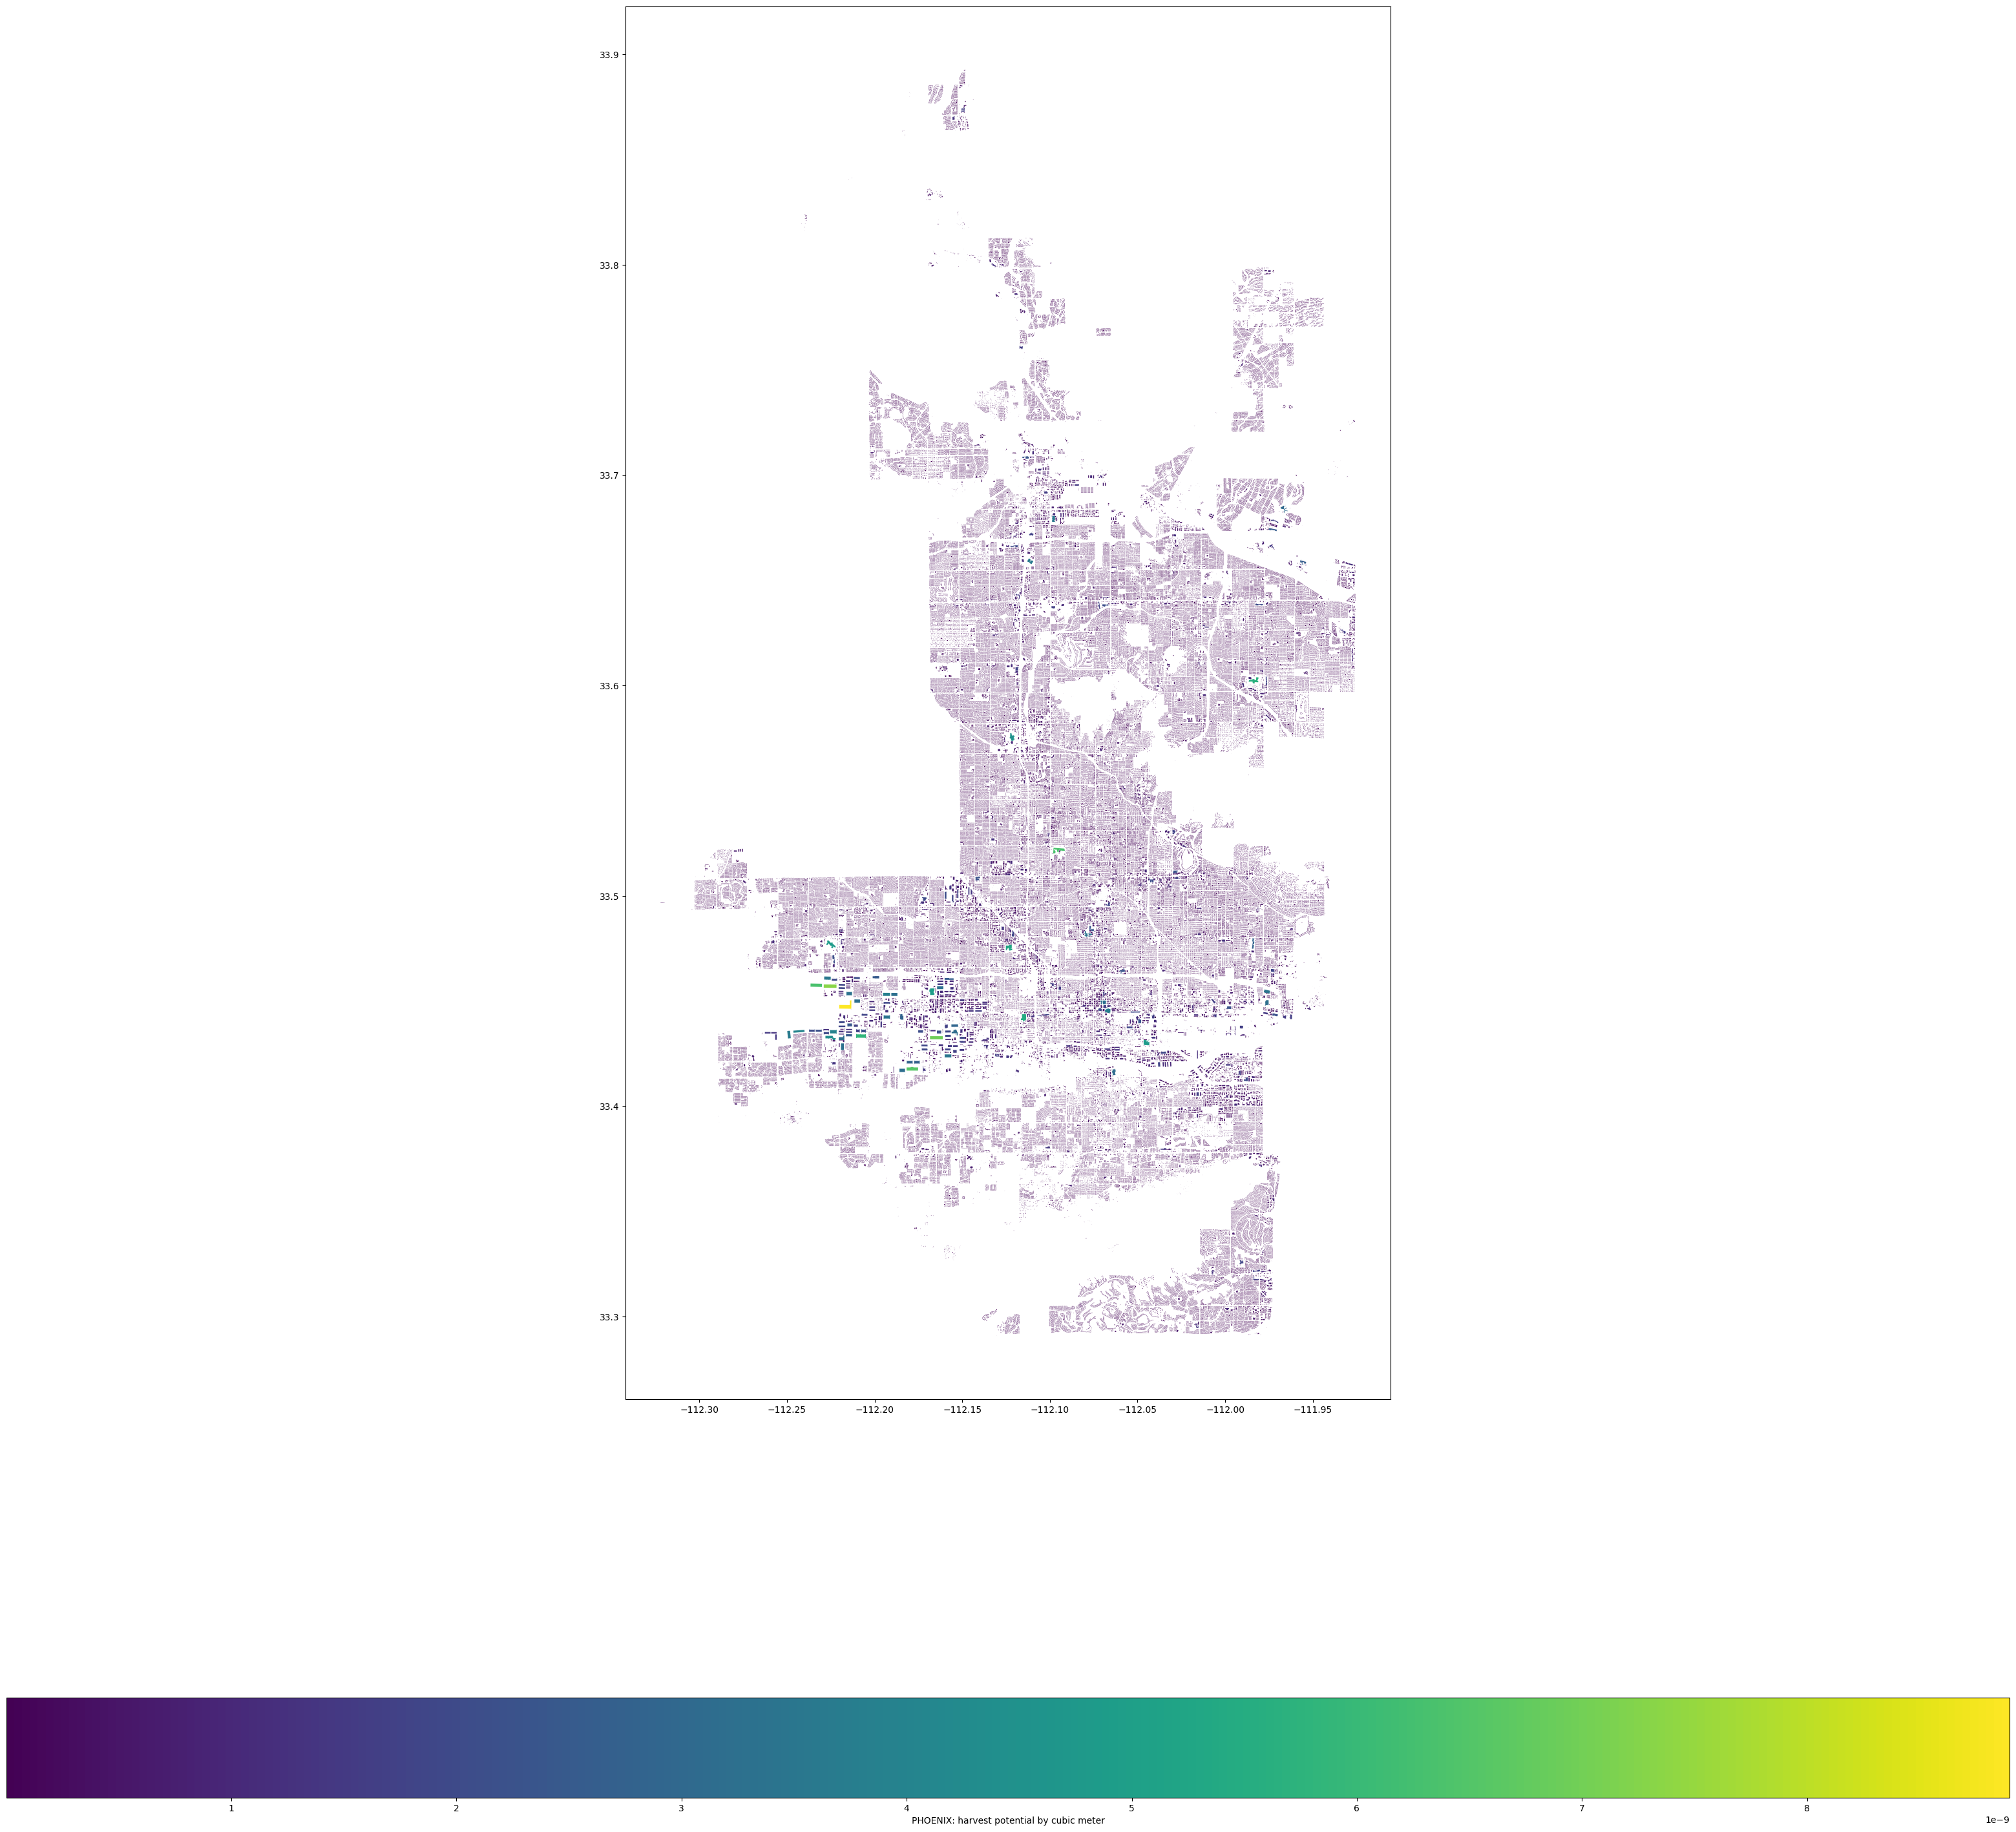

In [58]:
print("\n\nPHOENIX:")
print(f'mean annual precip (m):                 {phnx["mean_precip_m"].mean()}')
print(f'deficit under average conditions (m^3): {phnx["mean_deficit_m3"].mean()}')
print(f'deficit under wettest conditions (m^3): {phnx["wet_deficit_m3"].mean()}')
print(f'deficit under driest conditions (m^3):  {phnx["arid_deficit_m3"].mean()}')

phnx.plot(column='mean_harvest_m3',
    figsize=(40, 80),
    legend=True,
    legend_kwds={
        'label': "PHOENIX: harvest potential by cubic meter",
        'orientation': "horizontal"})




TUCSON:
mean annual precip (m):                 0.0008038590895012021
deficit under average conditions (m^3): 16.58009579997878
deficit under wettest conditions (m^3): 16.58009579989165
deficit under driest conditions (m^3):  16.580095800000002


<AxesSubplot: >

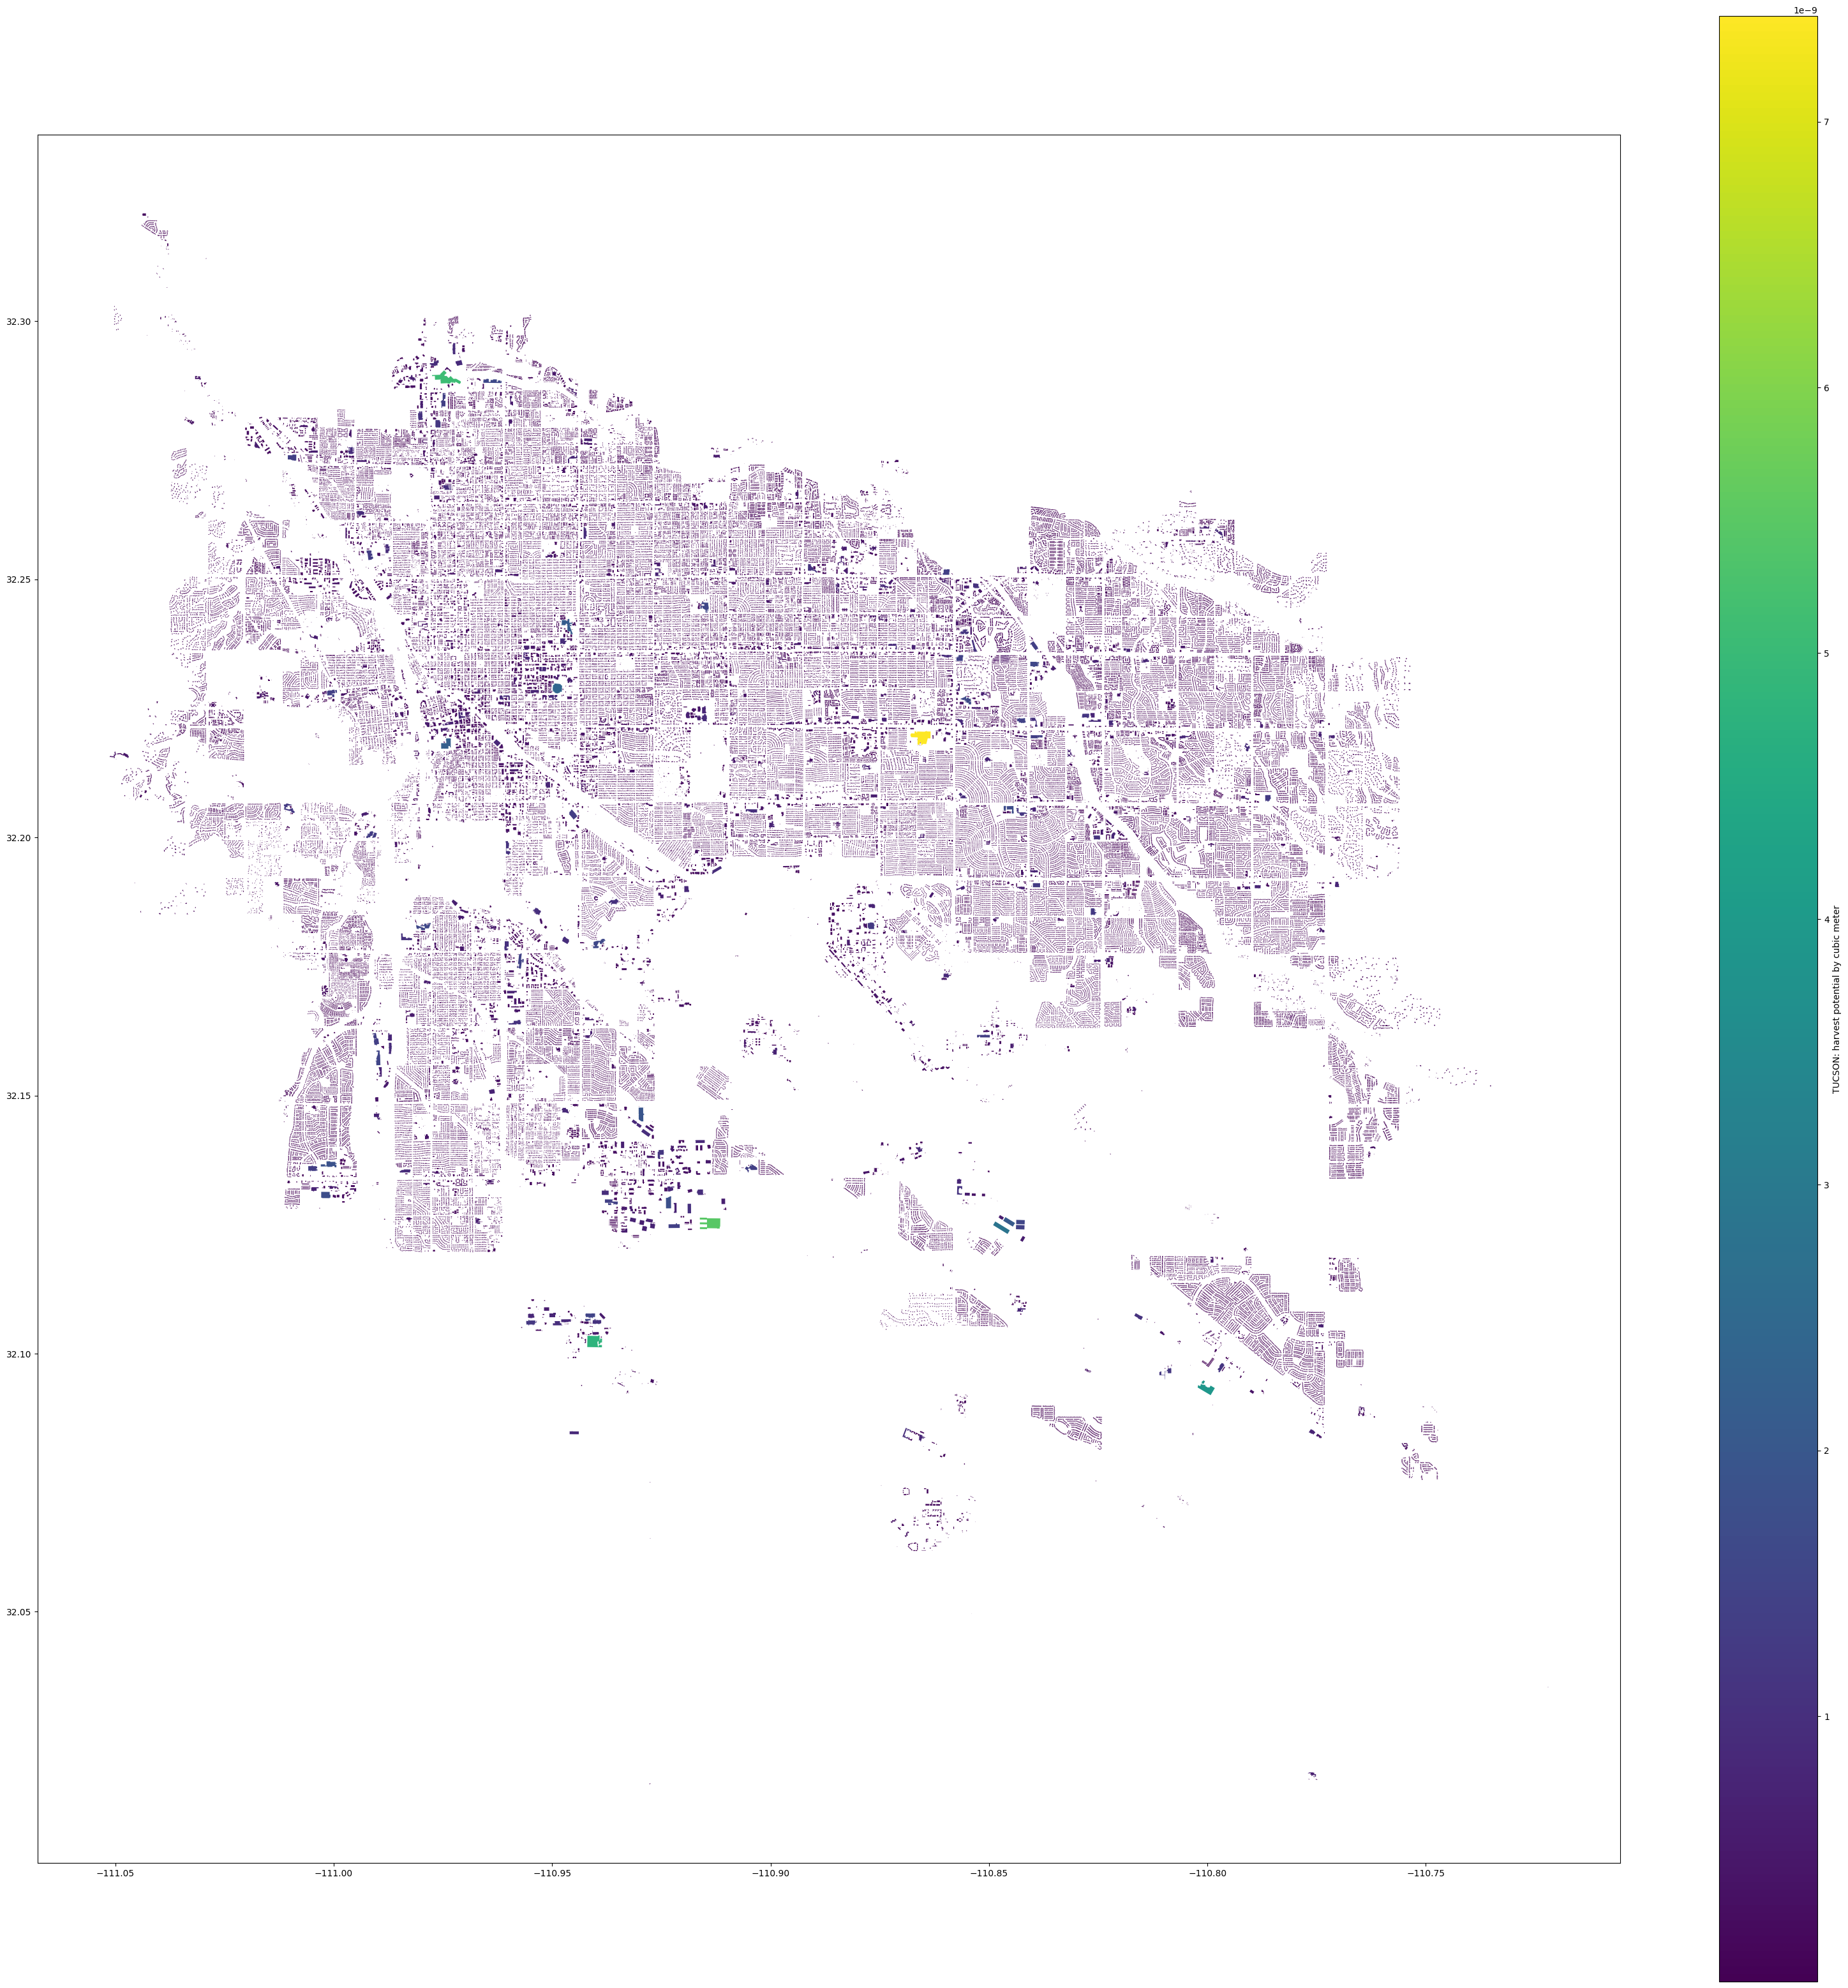

In [50]:
print("\n\nTUCSON:")
print(f'mean annual precip (m):                 {tucs["mean_precip_m"].mean()}')
print(f'deficit under average conditions (m^3): {tucs["mean_deficit_m3"].mean()}')
print(f'deficit under wettest conditions (m^3): {tucs["wet_deficit_m3"].mean()}')
print(f'deficit under driest conditions (m^3):  {tucs["arid_deficit_m3"].mean()}')

tucs.plot(column='mean_harvest_m3',  
           figsize=(40, 40),
           legend=True,
           legend_kwds={'label': "TUCSON: harvest potential by cubic meter"})
